In [1]:
!pip install tqdm

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
k=10 # this represents 10armed bandit
num_problems=2000#simulating 2000 independent bandit

q_star = np.random.normal(0, 1, (num_problems,k))#gausian distribution
arms=[0]*k

for i in range(10):
    arms[i]=np.random.normal(q_star[0,i],1,2000)# 1st problem as a sample


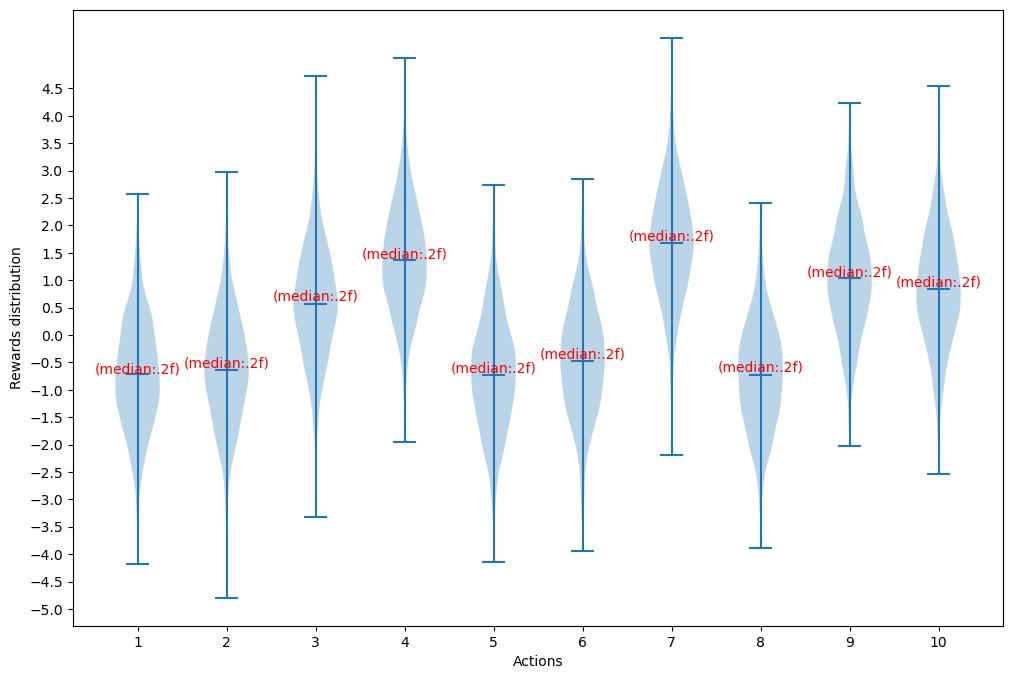

In [4]:
plt.figure(figsize=(12,8))
plt.ylabel('Rewards distribution')
plt.xlabel('Actions')
plt.xticks(range(1,11))
plt.yticks(np.arange(-5,5,0.5))

plt.violinplot(arms,positions=range(1,11),showmeans=True)
medians=[np.median(arms[i]) for i in range(10)]

for i, median in enumerate(medians,start=1):
    plt.text(i,median,f'(median:.2f)',ha='center',va='bottom',fontsize=10,color='red')

plt.show()

In [5]:
#Incremental implementations

In [6]:
def bandit(action,problem):
    return np.random.normal(q_star[problem,action],1)#fetches the true mean reward of the selected action in the specified problem instance.
#q_star[problem,action]- true reward value

In [7]:
def simple_max(Q,N,t):
# return np.argmax(Q)
    return  np.random.choice(np.flatnonzero(Q==Q.max())) #if same value persists then it breaks the ties by slecting any one randomely
    

In [36]:
def simple_bandit(k, epsilon, steps, initial_Q, alpha=0, argmax_func=simple_max):
  rewards=np.zeros(steps)
  actions=np.zeros(steps)
  for i in tqdm(range(num_problems)):
    Q=np.ones(k) *initial_Q
    N=np.zeros(k)
    best_action = np.argmax(q_star[i])
    for t in range(steps):
      if np.random.rand()<epsilon:
        a=np.random.randint(k)
      else:
        a=argmax_func(Q,N,t)
      reward=bandit(a,i)
      N[a]+=1
      if alpha>0:
        Q[a]=Q[a]+(reward-Q[a])*alpha
      else:
        Q[a]=Q[a]+(reward-Q[a])/N[a]
      rewards[t]+=reward
      if a == best_action:
        actions[t]+=1
  return rewards/num_problems, actions/num_problems

In [30]:
ep_0,ac_0=simple_bandit(k=10,epsilon=0,steps=1000,initial_Q=0)
ep_01,ac_01=simple_bandit(k=10,epsilon=0.01,steps=1000,initial_Q=0)
ep_1,ac_1=simple_bandit(k=10,epsilon=0.1,steps=1000,initial_Q=0)

100%|██████████| 2000/2000 [02:25<00:00, 13.77it/s]


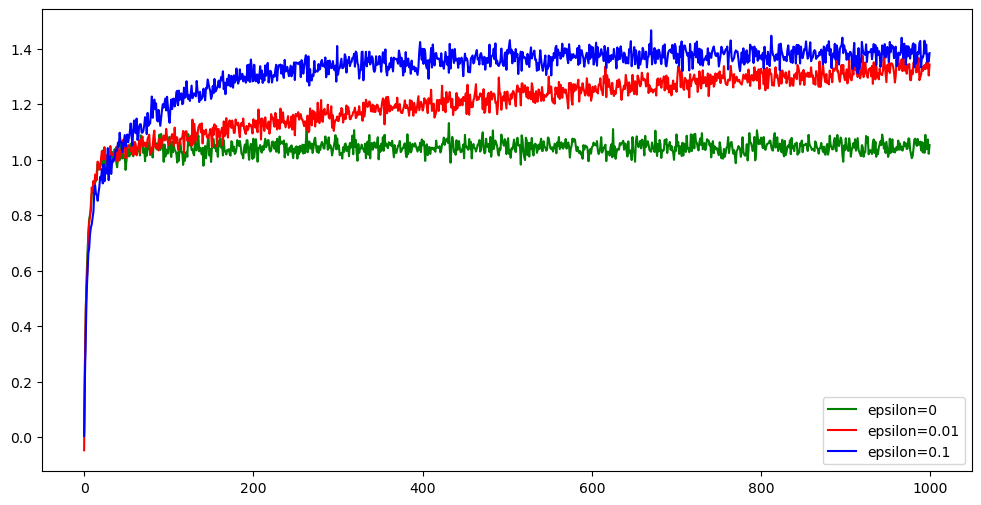

In [32]:
plt.figure(figsize=(12,6))
plt.plot(ep_0,'g', label='epsilon=0')
plt.plot(ep_01,'r', label='epsilon=0.01')
plt.plot(ep_1,'b', label='epsilon=0.1')
plt.legend()
plt.show()

In [38]:
opt_0, ac_opt_0=simple_bandit(k=10, epsilon=0, steps=1000, initial_Q=5, alpha=0.2)

100%|██████████| 2000/2000 [02:35<00:00, 12.86it/s]


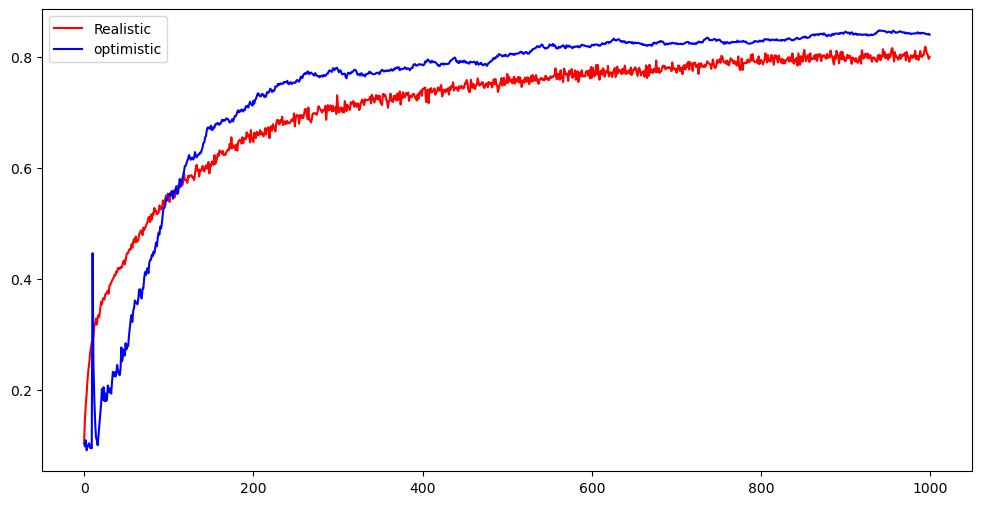

In [42]:
plt.figure(figsize=(12,6))
plt.yticks(np.arange(0,3,0.2))
plt.plot(ac_1,'r',label='Realistic')
plt.plot(ac_opt_0,'b',label='optimistic')
plt.legend()
plt.show()

In [48]:
def ucb(Q,N,t):#function using UCB for action selection problem
    C=2
    if N.min()==0:
        return np.random.choice(np.flatnonzero(N==N.min()))

    M=Q+C*np.sqrt(np.divide(np.log(t),N))
    return np.argmax(M) # breaking ties randomly


In [50]:
ucb_2,ac_ucb_2=simple_bandit(k=10,epsilon=0,steps=1000,initial_Q=0,argmax_func=ucb)

100%|██████████| 2000/2000 [00:58<00:00, 34.28it/s]


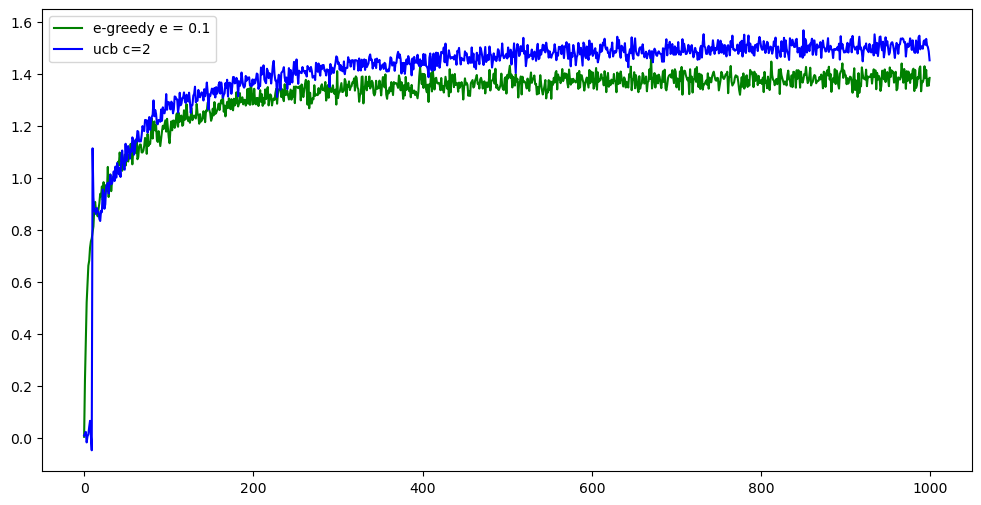

In [52]:
plt.figure(figsize=(12,6))
plt.plot(ep_1, 'g', label='e-greedy e = 0.1')
plt.plot(ucb_2, 'b', label='ucb c=2')
plt.legend()
plt.show()

In [73]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    M = e_x / e_x.sum()
    return np.argmax(M), M

In [ ]:
def gradient_bandit(k, steps, alpha, initial_Q, is_baseline=True):
    rewards = np.zeros(steps)
    actions = np.zeros(steps)

    for i in tqdm(range(num_problems)):
        Q = np.ones(k) * initial_Q #initial Q estimates action values (not used for seleciton bur for learning).
        N = np.zeros(k) # initialize number of rewards given
        R = np.zeros(k) # Rewards
        H = np.zeros(k) # initialize preferences keeps track of action preferecnes (higher means more likely to be chosen).
        pi = np.zeros(k) #stores the softmax probability distribution.
        best_action = np.argmax(q_star[i]) # best action of i'th problem

        for t in range(steps):
            a, pi = softmax(H)

            reward = bandit(a, i)
            N[a] += 1
            Q[a] = Q[a] + (reward - Q[a]) / N[a]

            for action_i in range(k):
                if action_i == a:
                    H[a] = H[a] + alpha * (reward - R[a]) * (1 - pi[a])
                else:
                    H[action_i] = H[action_i] - alpha* (reward-R[action_i]) * pi[action_i]

            if is_baseline == True:
                R[a] = Q[a]
            rewards[t] += reward
            if a == best_action:
                actions[t] += 1 

    return np.divide(rewards, num_problems), np.divide(actions, num_problems)

In [81]:
sft_4,ac_sft_4=gradient_bandit(k=10,steps=1000,alpha=0.4,initial_Q=0,is_baseline=False)
sft_4_baseline,ac_sft_4_baseline=gradient_bandit(k=10,steps=1000,alpha=0.4,initial_Q=0,is_baseline=True)

100%|██████████| 2000/2000 [01:16<00:00, 26.08it/s]


In [89]:
sft_1,ac_sft_1=gradient_bandit(k=10,steps=1000,alpha=0.1,initial_Q=0,is_baseline=False)
sft_1_baseline,ac_sft_1_baseline=gradient_bandit(k=10,steps=1000,alpha=0.1,initial_Q=0,is_baseline=True)

100%|██████████| 2000/2000 [01:15<00:00, 26.66it/s]


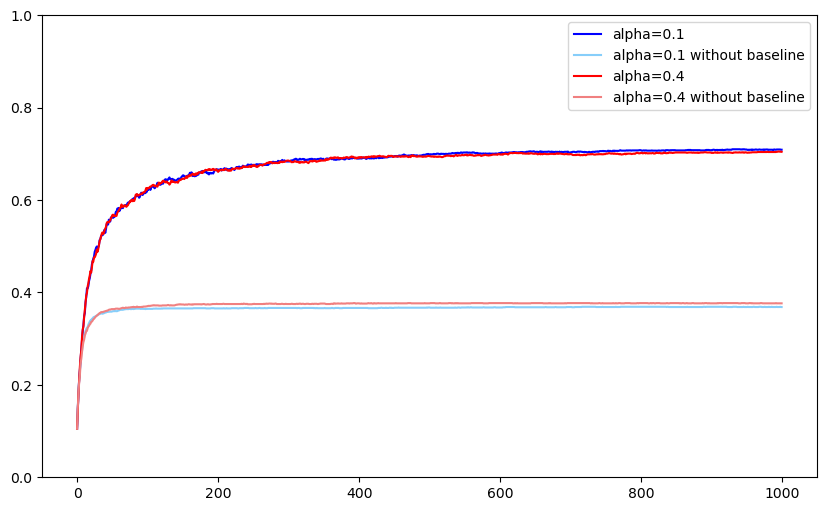

In [93]:
plt.figure(figsize=(10,6))
plt.ylim([0,1])
plt.plot(ac_sft_4_baseline,'b',label='alpha=0.1')
plt.plot(ac_sft_4,'lightskyblue',label='alpha=0.1 without baseline')
plt.plot(ac_sft_1_baseline,'r',label='alpha=0.4')
plt.plot(ac_sft_1,'lightcoral',label='alpha=0.4 without baseline')
plt.legend()
plt.show()